# Vehicles Wrangle
This document is to be run 3rd (optionally after 03a-EDA, they are not dependent on each other)\
The purpose of this document is to justify wrangling steps, the actual wrangling functions are inside functions.R.

In [63]:
#Import Necessary libraries
library('tidyverse')
library('dplyr')
library('forcats')
source('functions.R')

In [64]:
#Read Data
trainVehicles = read.csv('03a-vehicles-sample.csv')
holdoutVehicles = read.csv('03b-vehicles-holdout.csv')

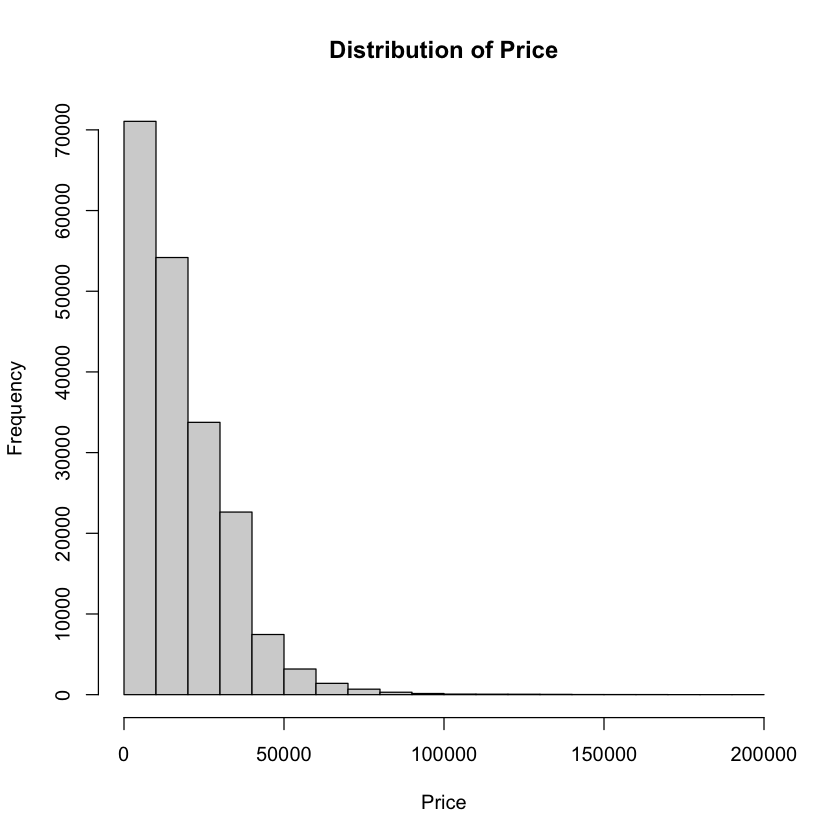

[1] -0.6635225

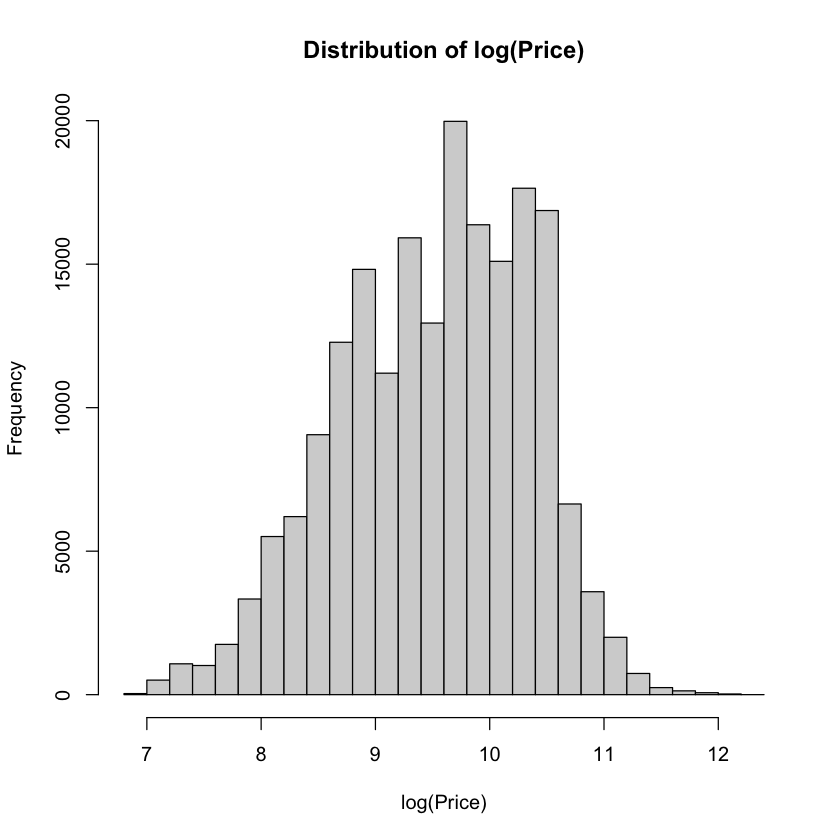

In [3]:
#Creating plots showing price
hist(trainVehicles$price, xlab = 'Price', main = 'Distribution of Price')
hist(log(trainVehicles$price), xlab ='log(Price)', main = 'Distribution of log(Price)')

#check numerical correlation
cor(trainVehicles$year,trainVehicles$odometer)

In [4]:
## Rough exploration, visuals not meant for presentation but possibly for report
# ggplot(aes(x = condition, y = log(price)), data = trainVehicles)+geom_boxplot() 
# ggplot(aes(x = manufacturer, y = log(price)), data = trainVehicles)+geom_boxplot() # too many manufacturers, crowded. pick sample?
# ggplot(aes(x = cylinders, y = log(price)), data = trainVehicles)+geom_boxplot() # technically this data is ordinal; transform and re-do?
# hist(trainVehicles$year,xlab = 'year', main = 'Frequency of Year') # already done above

# summary(trainVehicles) # useful but ugly and already saved elsewhere; save again with new data split?

# trainVehicles %>% group_by(manufacturer) %>% summarise(no_rows = length(manufacturer))
# manufacturerCount = trainVehicles %>% count(manufacturer) %>% filter(n > 1500)

## shows all manufacturers with NAs dropped, crowded and ugly
# manufacVehicles = !trainVehicles$manufacturer %in% manufacturerCount$manufacturer
# trainVehicles2 = trainVehicles
# trainVehicles2[manufacVehicles, ]$manufacturer <- NA 
# ggplot(aes(x = manufacturer, y = log(price)), data = trainVehicles2)+geom_boxplot() 

# Condition
Dropped "like new" and "salvage" because they have very few entries; also "new" cars are not likely to be sold on craigslist
Consider combining "new" into "like new"? 
Should probably drop salvage completely

condition,no_rows
<chr>,<int>
,69731
excellent,50158
fair,2776
good,59523
like new,12023
new,612
salvage,241


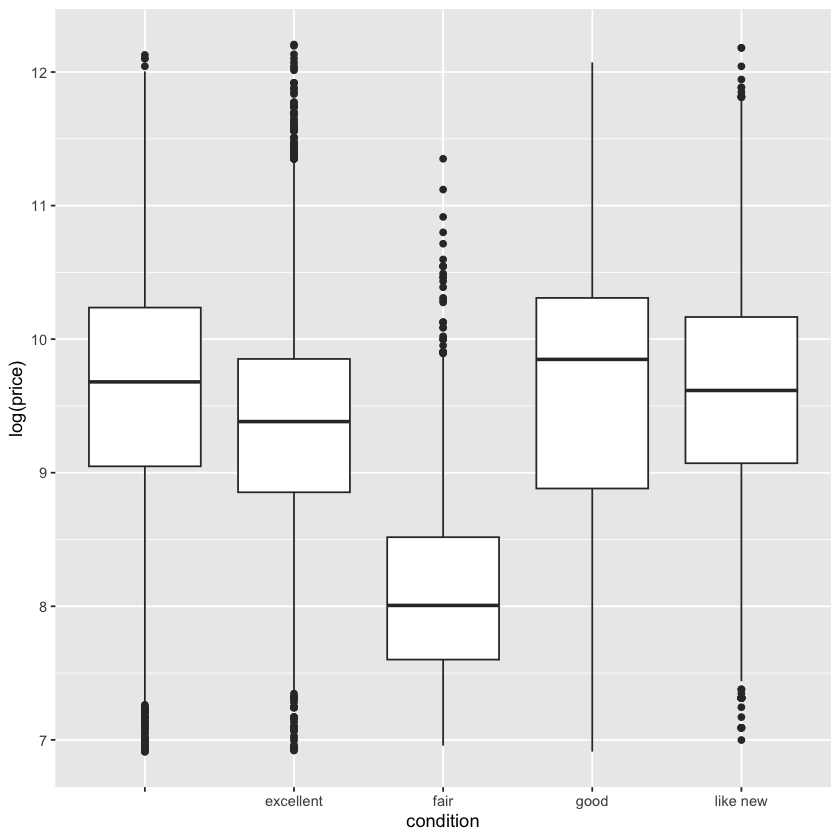

In [5]:
trainVehicles %>% group_by(condition) %>% summarise(no_rows = length(condition))

v3 = trainVehicles %>% filter(condition == "" | condition == "excellent" | condition == "fair"  | condition == "like new" | condition == "good")
ggplot(aes(x = condition, y = log(price)), data = v3)+geom_boxplot()

In [6]:
## Raw boxplots
# ggplot(aes(x = cylinders, y = log(price)), data = trainVehicles)+geom_boxplot()
# ggplot(aes(x = fuel, y = log(price)), data = trainVehicles)+geom_boxplot()
# ggplot(aes(x = transmission, y = log(price)), data = trainVehicles)+geom_boxplot()
# ggplot(aes(x = drive, y = log(price)), data = trainVehicles)+geom_boxplot()
# ggplot(aes(x = type, y = log(price)), data = trainVehicles)+geom_boxplot()
# ggplot(aes(x = paint_color, y = log(price)), data = trainVehicles)+geom_boxplot()
# ggplot(aes(x = state, y = log(price)), data = trainVehicles)+geom_boxplot()

# Vehicle Type and Size
## Size
"Size" is a created variable:
LARGE: 
bus
mini-van
offroad
pickup
SUV
truck
van
wagon

"MEDIUM":
convertible
hatchback
sedan 
coupe
## Type
Took out very small categories for visualization

Here we can see that offroad and bus are very small categories

type,no_rows
<chr>,<int>
,41715
SUV,37621
bus,238
convertible,3130
coupe,7950
hatchback,8384
mini-van,2744
offroad,227
other,9426


Size,no_rows
<fct>,<int>
medium,61752
large,82171
NA,51141


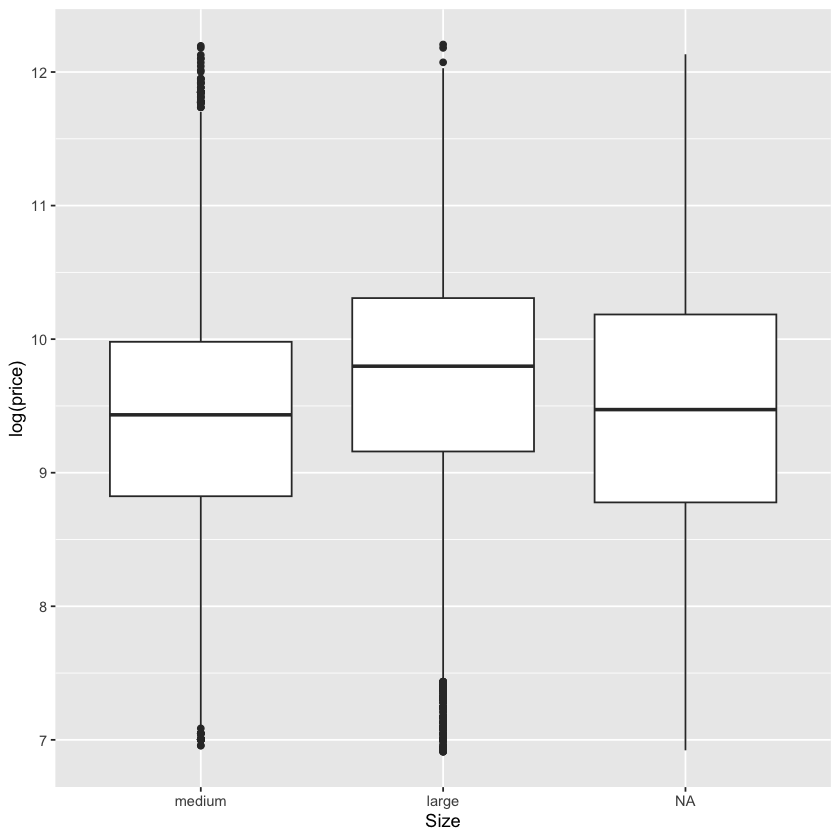

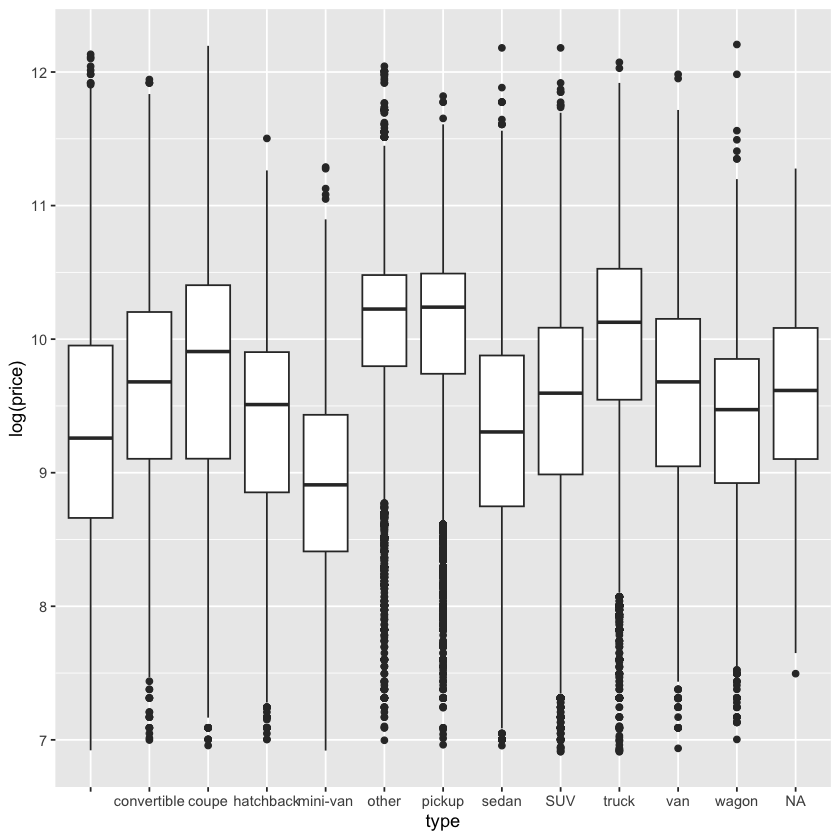

In [7]:
trainVehicles %>% group_by(type) %>% summarise(no_rows = length(type))

# going by https://uglab.stat.ubc.ca/~h.joe/stat447-2023/Notes/stat447-coding1.pdf
    # page 7
    # grouped vehicle types into categories
size=trainVehicles$type
size[size=="convertible"]="medium";size[size=="hatchback"]="medium";size[size=="sedan"]="medium";size[size=="coupe"]="medium"
size[size=="bus"]="large"; size[size=="mini-van"]="large"; size[size=="offroad"]="large"; size[size=="pickup"]="large"
size[size=="SUV"]="large"; size[size=="truck"]="large"; size[size=="van"]="large"; size[size=="wagon"]="large"
trainVehicles$Size=factor(size,levels=c("medium","large"))
ggplot(aes(x = Size, y = log(price)), data = trainVehicles)+geom_boxplot() 
trainVehicles %>% group_by(Size) %>% summarise(no_rows = length(Size))

typeCount = trainVehicles %>% count(type) %>% filter(n > 1500)

typeVehicles = !trainVehicles$type %in% typeCount$type
trainVehicles3 = trainVehicles
trainVehicles3[typeVehicles, ]$type <- NA 
ggplot(aes(x = type, y = log(price)), data = trainVehicles3)+geom_boxplot() 

Here it appears it may be too general to bin by size, hence we can use the custom function 'type_bin' to roll bus and off-road types into other.

# Fuel
Very few electric, considering adding them to Hybrid and re-name the category?

fuel,no_rows
<chr>,<int>
,1041
diesel,12150
electric,849
gas,165360
hybrid,2753
other,12911


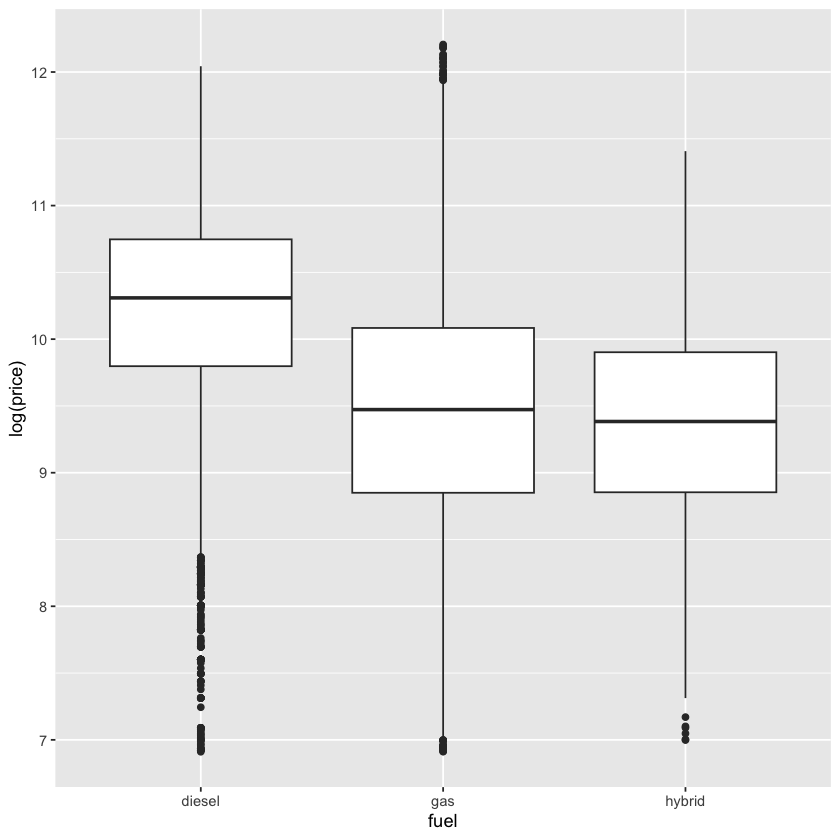

In [8]:
trainVehicles %>% group_by(fuel) %>% summarise(no_rows = length(fuel))

v4 = trainVehicles %>% filter(fuel == "diesel" | fuel == "gas" | fuel == "hybrid")
ggplot(aes(x = fuel, y = log(price)), data = v4)+geom_boxplot()

# Goodman and Kruskal's Tau
### sqrt(GoodmanKruskal tau) in library(GKtau) can be used for the continuous response versus some categorical features (such as room type) after the response variable has been binned.

### The Goodman and Kruskal tau measure is an asymmetric association measure between two categorical variables, based on the extent to which variation in one variable can be explained by the other. This function returns a dataframe with both forward and backward associations.

In [9]:
install.packages("GoodmanKruskal")


The downloaded binary packages are in
	/var/folders/tl/xlgvkb3526jcqrsmhf8p2fh40000gn/T//Rtmp0TRWWd/downloaded_packages


In [10]:
# bin the response variable
trainVehicles <- trainVehicles %>% mutate(price_bins = cut(log(price), breaks = c(7,8,9,10,11,12)))
# head(cleanedVehicles, 10)
trainVehicles%>%group_by(price_bins)%>%count() # excludes 21 rows

library(GoodmanKruskal)
# GKtauDataframe(trainVehicles, includeNA = "no") ## WARNING DO NOT USE

## TODO: put these into a dataframe
# GKtau(trainVehicles$type, trainVehicles$fuel)
# GKtau(trainVehicles$type, trainVehicles$manufacturer)
# GKtau(trainVehicles$type, trainVehicles$price_bins)
# GKtau(trainVehicles$manufacturer, trainVehicles$price_bins)
# GKtau(trainVehicles$condition, trainVehicles$price_bins)
# GKtau(trainVehicles$fuel, trainVehicles$price_bins)

price_bins,n
<fct>,<int>
"(7,8]",7683
"(8,9]",47870
"(9,10]",76418
"(10,11]",59845
"(11,12]",3185
NA,63


## Car Price and Age

In [11]:
trainVehicles$age = ageVehicle(trainVehicles)

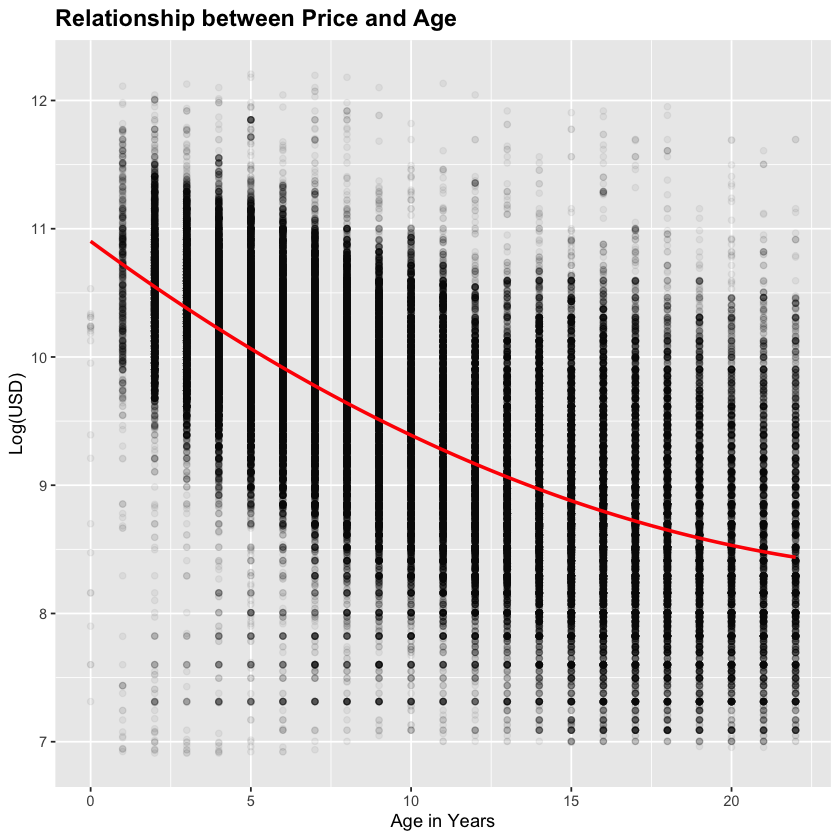

In [12]:
ggplot(data = trainVehicles, aes(x = age, y = log(price))) + geom_point(alpha = 0.05,col = 'black') + 
    geom_smooth(method = lm,formula = y ~ poly(x,2), col = 'red') + labs(x='Age in Years', y = 'Log(USD)') + ggtitle('Relationship between Price and Age') +
    theme(plot.title = element_text(color = "black", size = 14, face = "bold"))

Here we see there is a negative relationship between age and car price with less dispersion around newer cars compared to older cars. We can expect that this will have implications for the heterscedasticity of model errors.

## Car Miles and Age

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


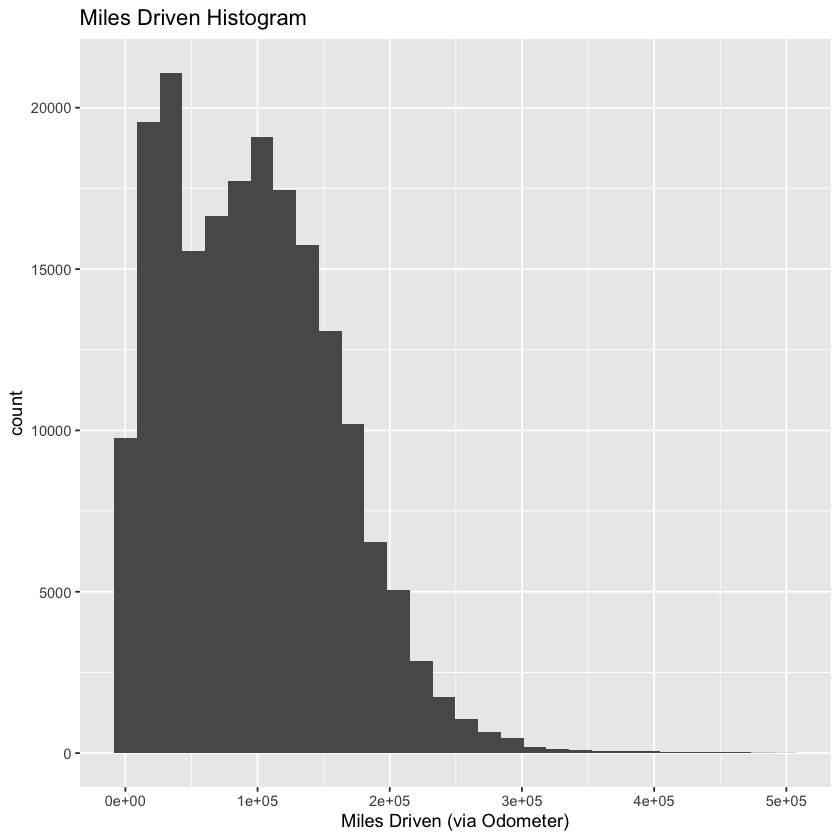

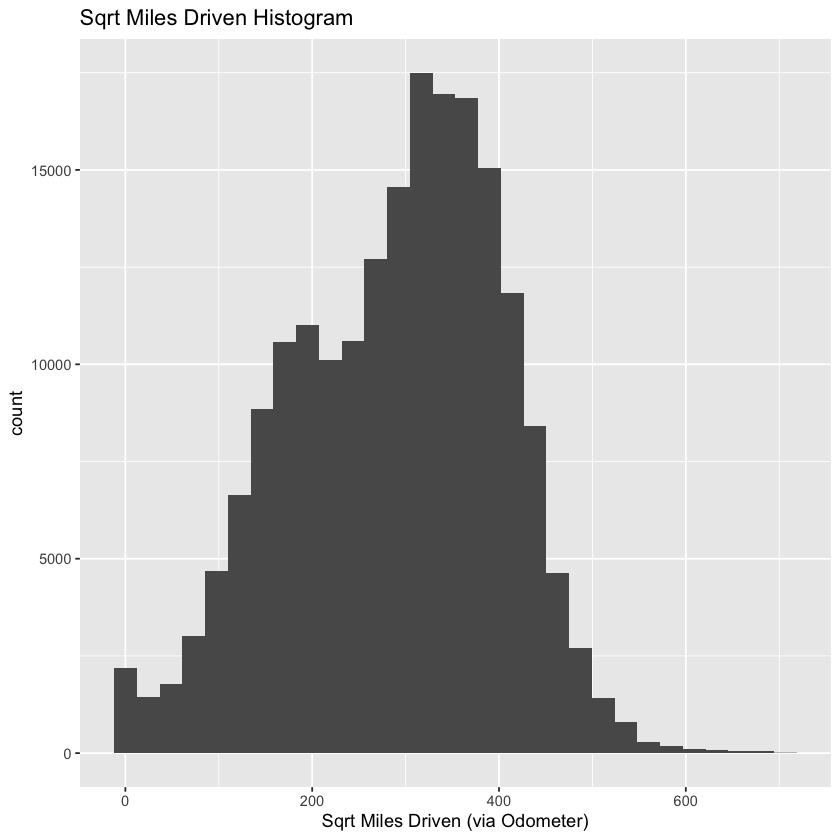

In [13]:
ggplot(data = trainVehicles,aes(x = odometer)) + geom_histogram() + labs(x = 'Miles Driven (via Odometer)', title = 'Miles Driven Histogram')
ggplot(data = trainVehicles,aes(x = sqrt(odometer))) + geom_histogram() + labs(x = 'Sqrt Miles Driven (via Odometer)', title = 'Sqrt Miles Driven Histogram')

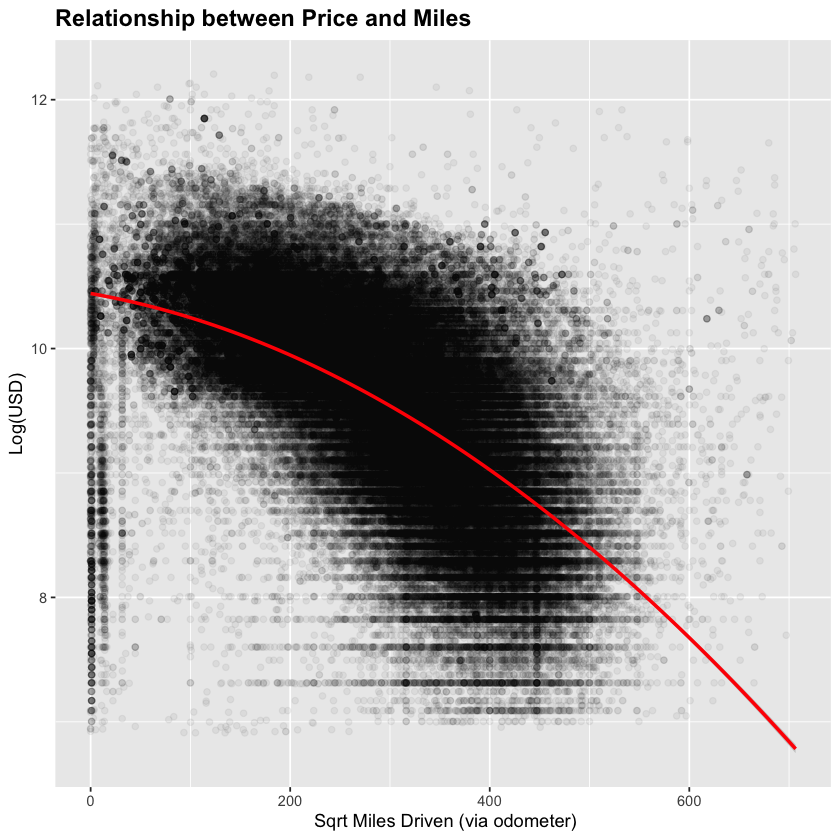

In [14]:
ggplot(data = trainVehicles, aes(x = sqrt(odometer), y = log(price))) + geom_point(alpha = 0.05,col = 'black') + 
    geom_smooth(method = lm,formula = y ~ poly(x,2), col = 'red') + labs(x=' Sqrt Miles Driven (via odometer)', y = 'Log(USD)') + ggtitle('Relationship between Price and Miles') +
    theme(plot.title = element_text(color = "black", size = 14, face = "bold"))

## Applying the wrangling function
see functions.R for documentation

In [65]:
#Reimport data to remove variables created above
trainVehicles = read.csv('03a-vehicles-sample.csv')
holdoutVehicles = read.csv('03b-vehicles-holdout.csv')

In [66]:
#apply wrangling function
wrangledTrainVehicles = wrangling_function(trainVehicles)
wrangledHoldoutVehicles = wrangling_function(holdoutVehicles)

In [67]:
head(wrangledTrainVehicles)

,price,condition,cylinders,fuel,title_status,transmission,drive,size,paint_color,state,type,countryOrigin,isLuxury,age,sqrt_odometer
,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
1,33590,good,8 cylinders,gas,clean,other,,,white,al,pickup,USA,0,8,240.6720
2,22590,good,8 cylinders,gas,clean,other,,,blue,al,pickup,USA,0,12,266.8876
3,39590,good,8 cylinders,gas,clean,other,,,red,al,pickup,USA,0,2,138.4197
4,30990,good,8 cylinders,gas,clean,other,,,red,al,pickup,Japan,0,5,202.7905
5,15000,excellent,6 cylinders,gas,clean,automatic,rwd,full-size,black,al,truck,USA,0,9,357.7709
6,27990,good,8 cylinders,gas,clean,other,4wd,,black,al,pickup,USA,0,10,262.0992


In [68]:
saveRDS(wrangledTrainVehicles, '04a-wrangledTrain.rds')
saveRDS(wrangledHoldoutVehicles, '04b-wrangledHoldout.rds')